# Run MILO on HSPC cells

This notebook performs MILO on HSPC cells.

**Dataset**: MIS-C dataset

**Type of cells**: HSPC

**DGE condition**: Different timepoints of disease status

**Inputs**: Filtered anndata object with HSPC cells only, `run_MAST.R` script

**Output**: Neighborhood and celltype plots

In [1]:
import rpy2
import anndata2ri
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpltern
import seaborn as sns
import anndata

In [2]:
anndata2ri.activate()
%load_ext rpy2.ipython

/scratch/lsftmp/8552890.tmpdir/ipykernel_43898/2547887543.py:1: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
anndata2ri.deactivate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
%%R
library(miloR)
library(igraph)
set.seed(42)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




# 1. Load in anndata

In [2]:
rna_ad = sc.read_h5ad('/data/niecr/cheongj/misc/results_seurat/anndata_obj/hspc_UNK_removed.h5ad')

In [3]:
rna_ad.obs.columns

Index(['og_barcode', 'batch_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes',
       ...
       'ConvPlas First Dose Date/time:', 'Site', 'Source',
       'Baseline: Green Top Tube Collected before IV IgG / Solumedrol',
       'Baseline: Tempus Collected before IV IgG / Solumedrol',
       'Baseline: SST Collected before IV IgG / Solumedrol', 'Comment Fields',
       'Disease.Status2', 'Disease.Status3', 'batch'],
      dtype='object', length=142)

In [7]:
rna_ad.obs[['Disease.Status3','batch','genotype_ID','celltype_v1']]

,Disease.Status3,batch,genotype_ID,celltype_v1
56#AAACCAACAAGGTGGC-1,Baseline_MIS-C,Batch 7,105,HSPC
56#AAACCGCGTACAATGT-1,D28_MIS-C,Batch 7,203,HSPC
56#AAACGCGCAGCTAATT-1,Baseline_MIS-C,Batch 7,105,HSPC
56#AAACGCGCAGTGAACG-1,Baseline_MIS-C,Batch 7,225,HSPC
56#AAACGCGCATATAACC-1,D28_MIS-C,Batch 7,207,HSPC
...,...,...,...,...
misc_b6_pie2#TTTGTCTAGCACCACA-1,D28_COVID,Batch 6,05,HSPC
misc_b6_pie2#TTTGTCTAGCTATTGA-1,D28_MIS-C,Batch 6,151,HSPC
misc_b6_pie2#TTTGTGAAGTCAGTAC-1,D28_MIS-C,Batch 6,151,HSPC
misc_b6_pie2#TTTGTGGCACAATTAC-1,D28_MIS-C,Batch 6,151,HSPC


In [38]:
obs_df = rna_ad.obs[['Disease.Status3','batch','genotype_ID','celltype_v1']].astype('str')
obs_df.columns = ['Condition', 'SampleID', 'IndivID', 'Celltype']
obs_df['Condition'] = obs_df['Condition'].str.replace('-', '_')
obs_df['Condition'] = obs_df['Condition'].str.replace(' ', '_')
obs_df['IndivID'] = obs_df['IndivID']+'_'+obs_df['Condition'] # IndivID has to be unique
obs_df

,Condition,SampleID,IndivID,Celltype
56#AAACCAACAAGGTGGC-1,Baseline_MIS_C,Batch 7,105_Baseline_MIS_C,HSPC
56#AAACCGCGTACAATGT-1,D28_MIS_C,Batch 7,203_D28_MIS_C,HSPC
56#AAACGCGCAGCTAATT-1,Baseline_MIS_C,Batch 7,105_Baseline_MIS_C,HSPC
56#AAACGCGCAGTGAACG-1,Baseline_MIS_C,Batch 7,225_Baseline_MIS_C,HSPC
56#AAACGCGCATATAACC-1,D28_MIS_C,Batch 7,207_D28_MIS_C,HSPC
...,...,...,...,...
misc_b6_pie2#TTTGTCTAGCACCACA-1,D28_COVID,Batch 6,05_D28_COVID,HSPC
misc_b6_pie2#TTTGTCTAGCTATTGA-1,D28_MIS_C,Batch 6,151_D28_MIS_C,HSPC
misc_b6_pie2#TTTGTGAAGTCAGTAC-1,D28_MIS_C,Batch 6,151_D28_MIS_C,HSPC
misc_b6_pie2#TTTGTGGCACAATTAC-1,D28_MIS_C,Batch 6,151_D28_MIS_C,HSPC


In [39]:
adata_milo = sc.AnnData(rna_ad.X.copy(), 
                                obs = obs_df, 
                                # var = adata.var[['highly_variable']]
                       )
adata_milo.obsm['X_pca'] = rna_ad.obsm['X_pca']
adata_milo.obsm['X_umap'] = rna_ad.obsm['X_draw_graph_fa']
adata_milo

AnnData object with n_obs × n_vars = 19092 × 27424
    obs: 'Condition', 'SampleID', 'IndivID', 'Celltype'
    obsm: 'X_pca', 'X_umap'

# 2. Run Milo in R

In [40]:
%%R -i adata_milo
adata_milo

class: SingleCellExperiment 
dim: 27424 19092 
metadata(0):
assays(1): X
rownames(27424): 0 1 ... 27422 27423
rowData names(0):
colnames(19092): 56#AAACCAACAAGGTGGC-1 56#AAACCGCGTACAATGT-1 ...
  misc_b6_pie2#TTTGTGGCACAATTAC-1 misc_b6_pie2#TTTGTGTTCCTCAGTC-1
colData names(4): Condition SampleID IndivID Celltype
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [41]:
%%R 
milo <- Milo(adata_milo)
milo

class: Milo 
dim: 27424 19092 
metadata(0):
assays(1): X
rownames(27424): 0 1 ... 27422 27423
rowData names(0):
colnames(19092): 56#AAACCAACAAGGTGGC-1 56#AAACCGCGTACAATGT-1 ...
  misc_b6_pie2#TTTGTGGCACAATTAC-1 misc_b6_pie2#TTTGTGTTCCTCAGTC-1
colData names(4): Condition SampleID IndivID Celltype
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [42]:
%%R
pca_result <- reducedDims(milo)$PCA
dim(pca_result)

[1] 19092    25


In [43]:
%%R
milo <- buildGraph(milo, k=30, d=25, reduced.dim = "PCA")
milo <- makeNhoods(milo, prop = 0.1, k = 30, d=25, refined = TRUE, reduced_dims = "PCA")

R[write to console]: Constructing kNN graph with k:30

R[write to console]: Checking valid object

R[write to console]: Running refined sampling with reduced_dim



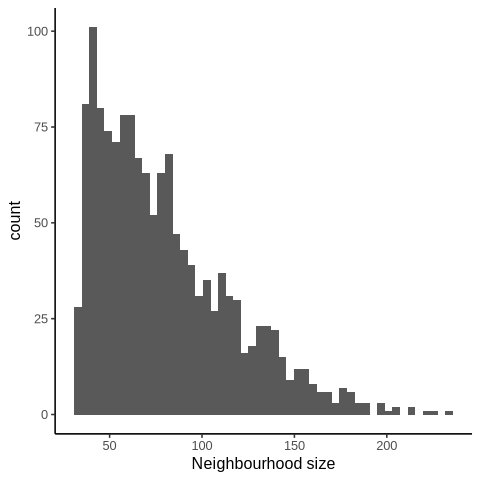

In [44]:
%%R 
plotNhoodSizeHist(milo)

The docs say this distribution should peak between 50 and 100, so I think we're good.

In [45]:
%%R
milo <- countCells(milo, meta.data = data.frame(colData(milo)), samples="IndivID")

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods



In [46]:
%%R
head(nhoodCounts(milo))

6 x 70 sparse Matrix of class "dgCMatrix"


R[write to console]:   [[ suppressing 70 column names ‘105_Baseline_MIS_C’, ‘203_D28_MIS_C’, ‘225_Baseline_MIS_C’ ... ]]



                                                                               
1 . . . . .  . . . 1  .  .  . . . . . .  .  . . . . . . . . . . . . . . . . 2 .
2 . . . . .  . . . 1  6  3  . . . . . . 13  2 . . . . 1 . . . . . . . . . . . .
3 1 2 . 2 . 22 1 2 .  3 21 70 2 3 2 1 .  .  4 1 . 1 1 1 . 1 . . . . . . . 4 2 .
4 1 . . . .  . . . . 31  2  . . . . . .  4 49 . . 1 . . . . . . . . . 1 . . . .
5 . . . . .  . . . 5  .  5  1 . 1 1 3 1  2  2 . . 2 . . . 2 . . . . . . . . . .
6 . . . . .  . . . .  .  1  . 1 . . . .  .  . . . . . . . 1 . . . . . . . . . .
                                                                        
1 . . . . . . . 1 5 . . 110 . . 1 . . 1 1 . . . . 2 . . . 5 .  . 1 . . .
2 . . . . . . . . . . .   . . . . . . . . 1 . 2 . . . . 1 . 9 16 4 . . .
3 . . 2 . . . . . . . .   . 1 . . . . . . 2 1 . . . . . 1 . 8  1 1 1 3 .
4 . 2 . . . 2 . . . . .   . 1 . . . . . . . . 1 . . . . . . .  . . . . .
5 . . . . . . . . . . .   . . . . . 1 . . . . . . . . . 7 3 .  4 2 . 1 3
6 

## 3. Differential abundance testing with contrasts

In [47]:
design_df = adata_milo.obs[["IndivID", "Condition"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df["IndivID"]
design_df

,IndivID,Condition
IndivID,,
105_Baseline_MIS_C,105_Baseline_MIS_C,Baseline_MIS_C
203_D28_MIS_C,203_D28_MIS_C,D28_MIS_C
225_Baseline_MIS_C,225_Baseline_MIS_C,Baseline_MIS_C
207_D28_MIS_C,207_D28_MIS_C,D28_MIS_C
31_MISC_recovered,31_MISC_recovered,MISC_recovered
...,...,...
05_D28_COVID,05_D28_COVID,D28_COVID
61_M12_POSSIBLE_MIS_C,61_M12_POSSIBLE_MIS_C,M12_POSSIBLE_MIS_C
151_D28_MIS_C,151_D28_MIS_C,D28_MIS_C


In [48]:
%%R
colnames(nhoodCounts(milo))

 [1] "105_Baseline_MIS_C"          "203_D28_MIS_C"              
 [3] "225_Baseline_MIS_C"          "207_D28_MIS_C"              
 [5] "31_MISC_recovered"           "276_D28_MIS_C"              
 [7] "50_MISC_recovered"           "141_M6_POSSIBLE_MIS_C"      
 [9] "unassigned_nan"              "31_Baseline_MIS_C"          
[11] "225_D28_MIS_C"               "276_MISC_recovered"         
[13] "203_MISC_recovered"          "105_D28_MIS_C"              
[15] "141_Baseline_POSSIBLE_MIS_C" "207_MISC_recovered"         
[17] "50_Baseline_MIS_C"           "31_D28_MIS_C"               
[19] "50_D28_MIS_C"                "105_MISC_recovered"         
[21] "203_Baseline_MIS_C"          "276_Baseline_MIS_C"         
[23] "207_Baseline_MIS_C"          "225_MISC_recovered"         
[25] "141_D28_POSSIBLE_MIS_C"      "nan_nan"                    
[27] "HD007_Healthy_Healthy"       "67_Baseline_MIS_C"          
[29] "260_D28_COVID"               "101_D28_COVID"              
[31] "16_Baseline_POSSIBL

In [49]:
%%R -i design_df
#design_df <- design_df[colnames(nhoodCounts(milo)), , drop=FALSE]
design_df

                                                IndivID               Condition
105_Baseline_MIS_C                   105_Baseline_MIS_C          Baseline_MIS_C
203_D28_MIS_C                             203_D28_MIS_C               D28_MIS_C
225_Baseline_MIS_C                   225_Baseline_MIS_C          Baseline_MIS_C
207_D28_MIS_C                             207_D28_MIS_C               D28_MIS_C
31_MISC_recovered                     31_MISC_recovered          MISC_recovered
276_D28_MIS_C                             276_D28_MIS_C               D28_MIS_C
50_MISC_recovered                     50_MISC_recovered          MISC_recovered
141_M6_POSSIBLE_MIS_C             141_M6_POSSIBLE_MIS_C       M6_POSSIBLE_MIS_C
unassigned_nan                           unassigned_nan                     nan
31_Baseline_MIS_C                     31_Baseline_MIS_C          Baseline_MIS_C
225_D28_MIS_C                             225_D28_MIS_C               D28_MIS_C
276_MISC_recovered                   276

In [56]:
%%R -o da_results_Baseline_MIS_C -o da_results_Baseline_COVID
contrast1 = 'ConditionBaseline_MIS_C - ConditionMISC_recovered'
contrast2 = 'ConditionBaseline_COVID - ConditionMISC_recovered'
da_results_Baseline_MIS_C <- testNhoods(milo, design = ~ 0 + Condition, design.df = design_df, model.contrasts = contrast1, fdr.weighting="graph-overlap")
da_results_Baseline_COVID <- testNhoods(milo, design = ~ 0 + Condition, design.df = design_df, model.contrasts = contrast2, fdr.weighting="graph-overlap")

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withgraph-overlap weighting

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withgraph-overlap weighting



In [57]:
%%R
table(da_results_Baseline_MIS_C$SpatialFDR < 0.1)


FALSE  TRUE 
  986   441 


In [58]:
%%R
table(da_results_Baseline_COVID$SpatialFDR < 0.1)


FALSE 
 1427 


In [59]:
da_results_Baseline_MIS_C

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,-0.749637,12.940723,0.563757,0.452753,0.632170,1.0,0.616324
2,0.186522,12.287526,0.086398,0.768808,0.890019,2.0,0.881320
3,-3.196907,13.027192,5.931986,0.014871,0.058657,3.0,0.052311
4,1.750492,12.457057,2.728726,0.098562,0.239604,4.0,0.219096
5,-0.920361,12.247737,1.012734,0.314252,0.497159,5.0,0.475524
...,...,...,...,...,...,...,...
1423,0.291822,12.277176,0.047583,0.827325,0.918749,1423.0,0.915687
1424,0.548181,12.120141,1.912901,0.270969,0.451339,1424.0,0.427590
1425,-2.382739,12.347214,5.890261,0.015227,0.059695,1425.0,0.053308
1426,1.349838,12.297126,2.026300,0.154600,0.323009,1426.0,0.298319


In [60]:
da_results_Baseline_COVID

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,-2.007435,12.940723,1.619156e+00,0.203213,0.361578,1.0,0.392496
2,-1.637294,12.287526,1.549408e+00,0.331913,0.470347,2.0,0.495071
3,-1.772876,13.027192,8.119307e-01,0.367553,0.511206,3.0,0.540161
4,-2.118379,12.457057,1.936679e+00,0.234703,0.374213,4.0,0.399851
5,-1.098994,12.247737,5.259105e-01,0.468333,0.609737,5.0,0.634836
...,...,...,...,...,...,...,...
1423,1.512215,12.277176,1.504122e+00,0.220042,0.374213,1423.0,0.399851
1424,0.000000,12.120141,0.000000e+00,1.000000,1.000000,1424.0,1.000000
1425,0.025197,12.347214,1.629703e-08,0.999898,1.000000,1425.0,1.000000
1426,-1.381304,12.297126,1.315319e+00,0.331913,0.470347,1426.0,0.495071


# 4. Plot results

## Baseline_MIS_C

Text(0, 0.5, '- log10(Spatial FDR)')

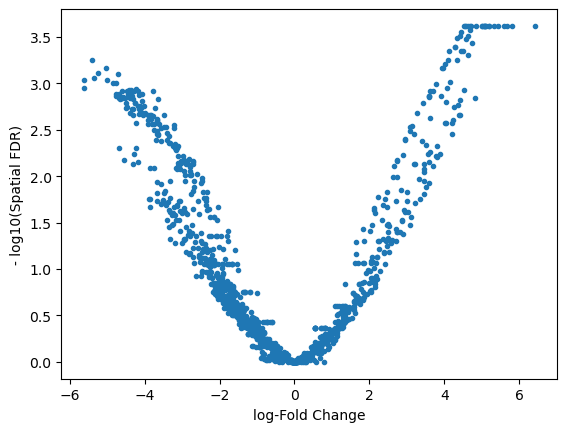

In [61]:
plt.plot(da_results_Baseline_MIS_C.logFC, -np.log10(da_results_Baseline_MIS_C.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

In [62]:
%%R
milo <- buildNhoodGraph(milo)

R[write to console]: Learn more about the underlying theory at https://ggplot2-book.org/



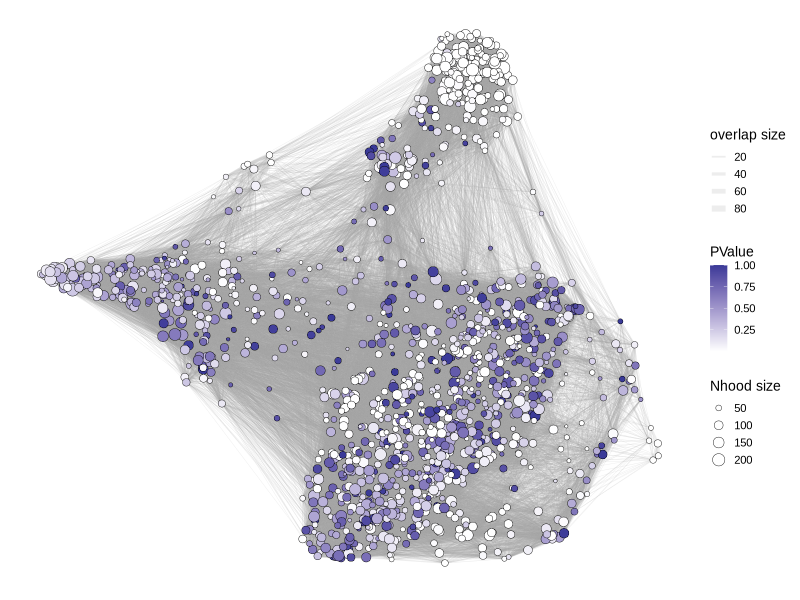

In [63]:
%%R -w 800 -h 600
library(ggplot2)
p1 <- plotNhoodGraphDA(milo, da_results_Baseline_MIS_C, alpha=1, layout="UMAP", res_column = 'PValue', size_range = c(1, 6))
p1

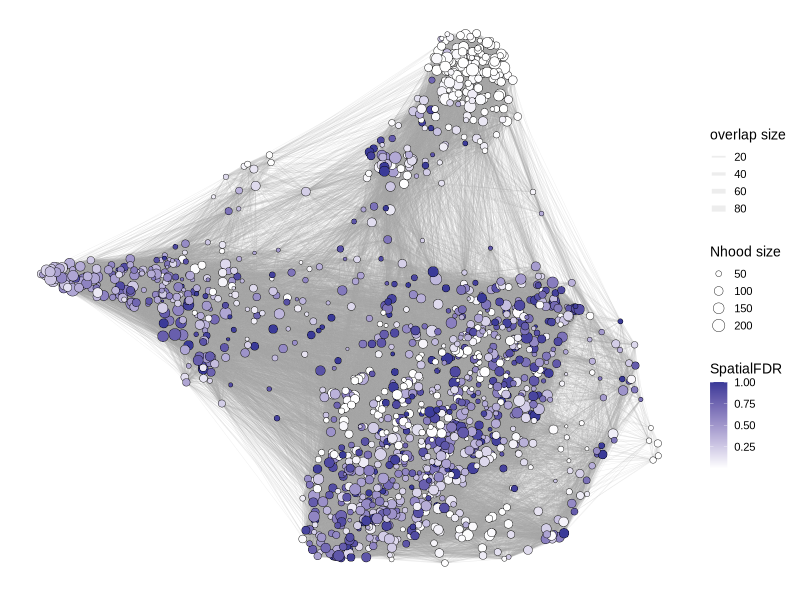

In [64]:
%%R -w 800 -h 600
library(ggplot2)
p1 <- plotNhoodGraphDA(milo, da_results_Baseline_MIS_C, alpha=1, layout="UMAP", res_column = 'SpatialFDR', size_range = c(1, 6))
p1

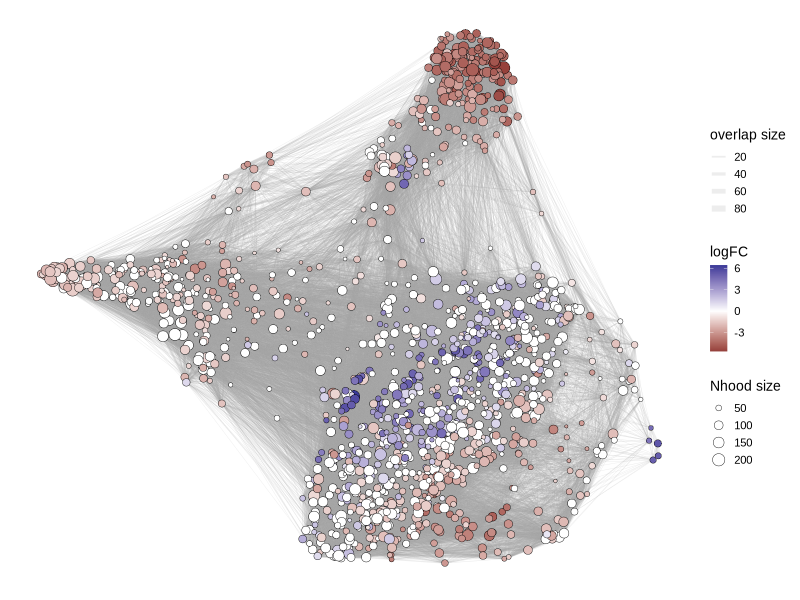

In [65]:
%%R -w 800 -h 600
library(ggplot2)
p1 <- plotNhoodGraphDA(milo, da_results_Baseline_MIS_C, alpha=0.5, layout="UMAP", size_range = c(1, 6))
# p1 = p1 + geom_text(data = DA_results, aes(x = label = Nhood))
p1

## Plot by celltype

In [57]:
%%R 
da_results_Baseline_MIS_C <- annotateNhoods(milo, da_results_Baseline_MIS_C, coldata_col = "hspc_subtype")
head(da_results_Baseline_MIS_C)

R[write to console]: Converting Celltype to factor...



        logFC   logCPM            F     PValue       FDR Nhood SpatialFDR
1 -1.16533367 14.13086 0.9691214396 0.32571528 0.4757157     1  0.4763280
2  1.63371840 14.23463 1.7681750837 0.18464705 0.3396349     2  0.3709239
3  0.46606872 14.27143 0.1468633840 0.70183018 0.7949301     3  0.8075814
4 -0.47328155 13.58897 0.1279623093 0.72081293 0.8054446     4  0.8139870
5 -2.80860685 13.95542 4.4334884058 0.03609514 0.1092861     5  0.1192437
6 -0.03078543 14.65134 0.0006886173 0.97908264 0.9875641     6  0.9863349
  Celltype Celltype_fraction
1  HSC_MPP         0.3750000
2     LMPP         0.9859155
3      MEP         1.0000000
4      MEP         0.5128205
5  HSC_MPP         0.8620690
6     LMPP         1.0000000


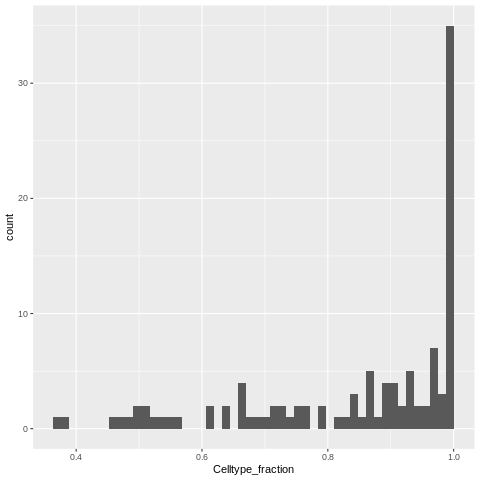

In [58]:
%%R
library(ggplot2)
ggplot(da_results_Baseline_MIS_C, aes(Celltype_fraction)) + geom_histogram(bins=50)

This confirms most neighborhoods are almost entirely one celltype.

R[write to console]: Converting group.by to factor...



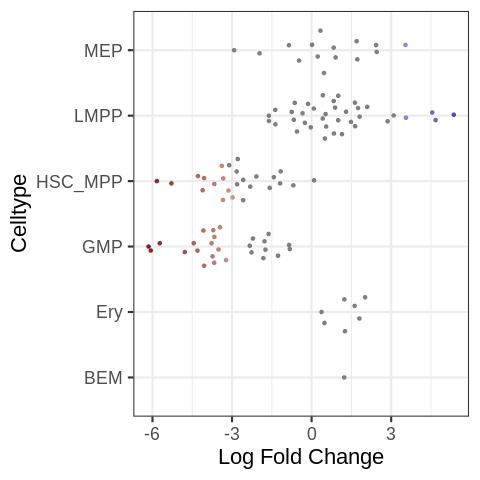

In [59]:
%%R
plotDAbeeswarm(da_results_Baseline_MIS_C, group.by = "hspc_subtype")